# PART 2 : IMPROVE THE F1_SCORE

In [114]:
# Loading librairies needed
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import joblib


In [115]:
# Loading dataset
dataset = pd.read_csv("src/conversion_data_train.csv")

In [116]:
# Visualize the 5 first rows
dataset.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [117]:
# Checking the shape
dataset.shape

(284580, 6)

STEP 2 : MISSING VALUE MANAGEMENT

In [118]:
dataset.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

STEP 3 : GETTING A SAMPLE OF THE DATASET

In [119]:
# Creating a dataset with 10000 observations
data = dataset.sample(10000)

STEP 4 : REPLACING THE NUMBER BY CORRESPONDING NAME CATEGORY

In [120]:
data['new_user'] = data["new_user"].apply(lambda x : "Yes" if x == 1 else "No")

In [121]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
74087,US,47,Yes,Seo,8,0
146731,China,30,Yes,Ads,4,0
84158,US,38,Yes,Ads,3,0
101463,US,26,No,Seo,8,0
281046,UK,34,No,Ads,2,0


STEP 5 : PREPROCESSSING

In [122]:
# Getting the list of columns
columns_list = data.columns.to_list()

In [123]:
# Splitting the name of features from the target variable
features_list = columns_list[:-1]
target_variable = "converted"

In [124]:
# Separating features from the target variable
X = data.loc[:, features_list]
y = data.loc[:, target_variable]

In [125]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['country', 'new_user', 'source']


In [126]:
# Dividing dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X ,y, 
                                                    test_size = 0.1, 
                                                    random_state=42)

In [127]:
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') 

In [128]:
# Create pipeline for numeric features
numeric_transformer = StandardScaler() 

In [129]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [130]:
# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)

# Label encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

# Preprocessings on test set
X_test = preprocessor.transform(X_test) 

# Label encoding
y_test = encoder.transform(y_test)


STEP 6 : TRAINING MODEL : DECISION TREE - WITH DATA_TRAIN.CSV

In [131]:
classifier = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 10)
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

...Done.
Best hyperparameters :  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best validation accuracy :  0.9823333333333334


In [132]:
# Predictions on training set
y_train_pred = gridsearch.predict(X_train)

# It's also possible to get the probabilities estimated by the model:
y_train_proba = gridsearch.predict_proba(X_train)

In [133]:
# Predictions on test set
y_test_pred = gridsearch.predict(X_test)

# It's also possible to get the probabilities estimated by the model:
y_test_proba = gridsearch.predict_proba(X_test)


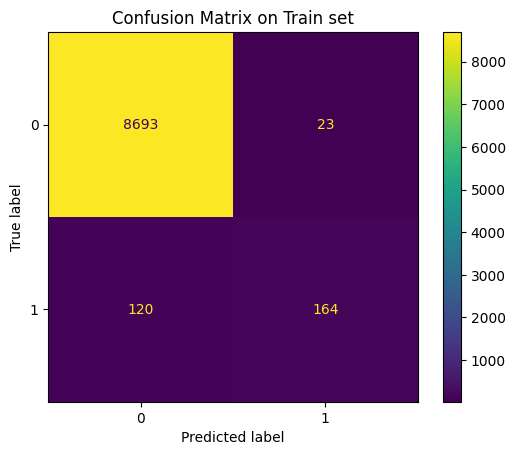

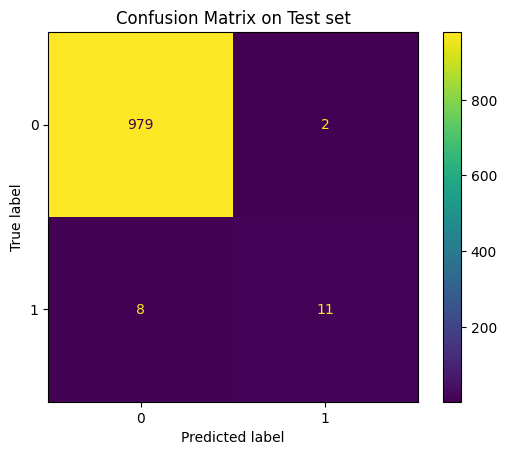

In [134]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [135]:
# Printing score F1_score
print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

f1-score on training set :  0.6963906581740976
f1-score on test set :  0.6875


STEP 7 : SAVE MODEL

In [136]:
joblib.dump(gridsearch.best_estimator_, "src/model.joblib", compress=3)

['src/model.joblib']

# END PART 2